# Skeweness Exploration

For many data science and machine learning applications, the data often have to be standardized in some form to make the ML operations more efficient. Large values and outliers can drastically effect the performance of some models.

When standardizing data, we often use the z-score method, which relys on the assumption of *normality*. **Skewness** can adversly affect the output of this kind of z-score standardization and cause ripple effects into the model we are trying to create

The goal is to explore skewness and the different ways it can be addressed appropriately.

In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import QuantileTransformer

We are first going to create some random data that would otherwise have a normal distribution and add skew to the data.

In [140]:
np.random.seed(130) # Set seed for reproducibility
x_norm = np.random.normal(loc = 1.0, size=1000)
skewed_error = np.random.exponential(scale=2.0, size=1000)
skewed_norm = np.add(x_norm, skewed_error)

x_norm = pd.Series(x_norm)
skewed_norm = pd.Series(skewed_norm)

Normal Skewness: 0.007
Skewed data Skewness: 1.669


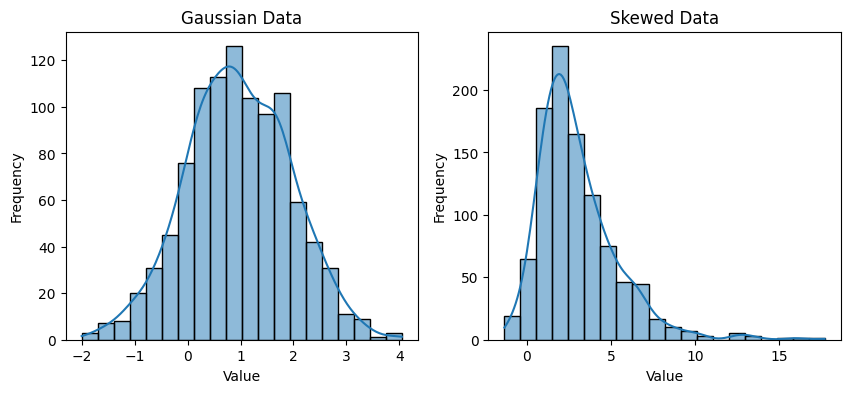

In [141]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(x_norm, bins=20, kde=True, ax=axes[0])
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Gaussian Data')

sns.histplot(skewed_norm, bins=20, kde=True, ax=axes[1])
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Skewed Data')

print('Normal Skewness:', x_norm.skew().round(3))
print('Skewed data Skewness:', skewed_norm.skew().round(3))

The above plots show the difference in the datasets. The left describes the normal data that we would need for z-score assumptions to work properly (skewness of 0.007). The right figure represents the right-skewed dataset (skewness of 1.669) which could cause problems during standardization.

## Log Transformation
One quick method that is often used is a log transformation on the feature data.

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


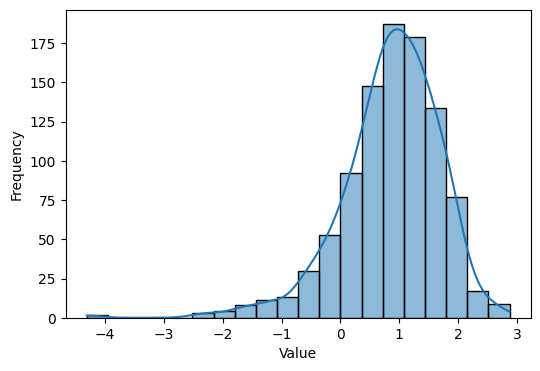

Log Skewness: -1.134


In [142]:
log_data = np.log(skewed_norm)

plt.figure(figsize=(6,4))
sns.histplot(log_data, bins=20, kde = True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

print('Log Skewness:', log_data.skew().round(3))

We can see that although the data is no longer right skewed, it now has the opposite problem. This is due to our data having some zero and negative values. As you may well know, negative numbers and ln do not mix. Below is a visula representation why.

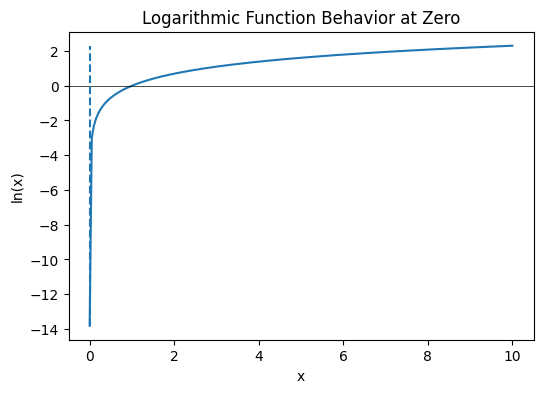

In [144]:
x = np.linspace(0.000001,10,200)
y = np.log(x)

plt.figure(figsize=(6,4))
plt.plot(x,y)
plt.axhline(y=0, color = 'black', linewidth = 0.5)
plt.vlines(x=0, ymin=y.min(), ymax=y.max(), linestyles='dashed')
plt.title('Logarithmic Function Behavior at Zero')
plt.xlabel('x')
plt.ylabel('ln(x)')
plt.show()

As you can see, the log function blows up asymptotically at zero, creating a left skew in our data as values near or close to zero blowing up and negative values likely being omitted entirely.

## Box Cox Transformation
Now we are going to try a different kind of transformation: Box Cox. This transformation involves raising the data the the power of the hyperparamter $λ$. When $λ = 0$ This is simply just the natural log transformation. We are going to use $λ = 0.5$ which corresponds to a square root transformation.
As to be expected (because the Box Cox is just the generalized transformation form of the log transformation) the Box Cox has issues with non-positive values.

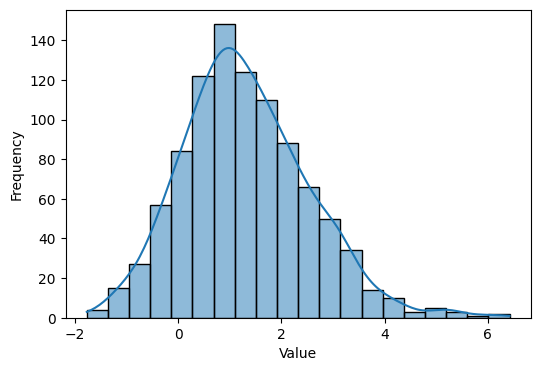

Box Cox (lambda = 0.5) skewness: 0.533


In [147]:
boxcox_data = stats.boxcox(skewed_norm, lmbda=0.5)

plt.figure(figsize=(6,4))
sns.histplot(boxcox_data, bins=20, kde = True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

boxcox_data = pd.Series(boxcox_data)
print('Box Cox (lambda = 0.5) skewness:', boxcox_data.skew().round(3))

We see better results that the log transformation, but there is likely something going on under the hood since we are not seeing an error but we know that this transformation cannot handle negative numbers. It's possible that a shift is being calculated before the transformation and then being undone after. Regardless, there are better alternatives.

## Yeo-Johnson Tranformation
The Yeo-Johnson transformation works similarly to the Box Cox but it allows for a larger range of values by using a piecewise function that changes at zero. This way we can use zero and negative values as inputs for the transformation as well.

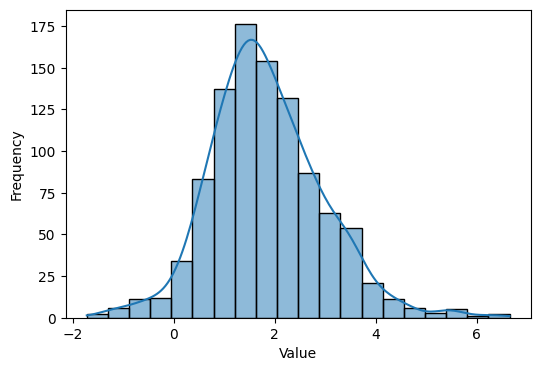

Yeo-Johnson data Skewness: 0.473


In [148]:
yj_data = stats.yeojohnson(skewed_norm, lmbda=0.5)

plt.figure(figsize=(6,4))
sns.histplot(yj_data, bins=20, kde = True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

yj_data = pd.Series(yj_data)
print('Yeo-Johnson data Skewness:', yj_data.skew().round(3))

We see better results here, and this would likely be close enough (depending on the application) to standardize for any ML models.
Lets take a look at one more method.

## Quantile Transformation
The quantile transformation is a very rubust transformer that compares quantiles of the skewed data with quantiles of a standard normal data and adjusts accordingly.

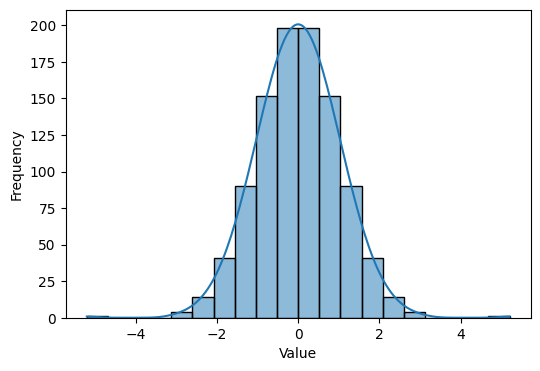

Quantile data Skewness: 0.0


In [134]:
qt = QuantileTransformer(output_distribution = 'normal')
quantile_data = qt.fit_transform(skewed_norm.values.reshape(-1,1)).flatten()
quantile_data = pd.Series(quantile_data)
plt.figure(figsize=(6,4))
sns.histplot(quantile_data, bins=20, kde = True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

print('Quantile data Skewness:', quantile_data.skew().round(3))

In [149]:
quantile_data.describe()

,0
count,1.000000e+03
mean,9.787193e-14
std,1.020366e+00
min,-5.199338e+00
25%,-6.744904e-01
50%,-2.086005e-16
75%,6.744904e-01
max,5.199338e+00


Here we see great results as it pertains to skewness (skewness = 0). This transformation actually gives us a very close approximation to the standard normal distribution.

It is important to note that though this eliminated our skewness, it also has its drawbacks. The quantile transformation can distort the distances between points and as a result you can lose valuble information about outliers, correlations, and even inccorect hypothesis tests.